In [1]:
import numpy as np
import os
import random
from collections import Counter
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import axes3d

In [2]:
def getData():
    trainFile = open("1b_benchmark.train.tokens", "r", encoding='utf-8')
    trainStr = trainFile.read()
    trainFile.close()
    trainFull = trainStr.split('\n')
    trainFull.pop()
    trainGrid = []
    for line in trainFull:
        splitLine = line.split(" ")
        splitLine.append("<<STOP>>")
        trainGrid.append(splitLine)

    devFile = open("1b_benchmark.dev.tokens", "r", encoding='utf-8')
    devStr = devFile.read()
    devFile.close()
    devFull = devStr.split('\n')
    devFull.pop()
    devGrid = []
    for line in devFull:
        splitLine = line.split(" ")
        splitLine.append("<<STOP>>")
        devGrid.append(splitLine)

    testFile = open("1b_benchmark.test.tokens", "r", encoding='utf-8')
    testStr = testFile.read()
    testFile.close()
    testFull = testStr.split('\n')
    testFull.pop()
    testGrid = []
    for line in testFull:
        splitLine = line.split(" ")
        splitLine.append("<<STOP>>")
        testGrid.append(splitLine)
    
    return trainGrid, devGrid, testGrid

In [3]:
trainGrid, devGrid, testGrid = getData()

def getUnique(inp, minFreq=3):
    frequency = dict()
    for sentence in inp:
        for word in sentence:
            count = frequency.get(word, 0)
            frequency.update({word : count + 1})
    vocabSet = set()
    for word in frequency:
        if frequency[word] >= minFreq:
            vocabSet.add(word)
    vocabSet.add("<<UNK>>")
    return vocabSet

def replaceUnk(inp, vocabSet):
    output = []
    for line in inp:
        curr = []
        for word in line:
            if word not in vocabSet:
                curr.append("<<UNK>>")
            else:
                curr.append(word)
        output.append(curr)
    return output

def padStart(inp, n):
    for line in inp:
        for i in range(n-1):
            line.insert(0, "<<START>>")

def prepTrain(vocabSet, inp, n):
    onlyVocab = replaceUnk(inp, vocabSet)
    padStart(onlyVocab, n)
    return onlyVocab

In [4]:
def unigramTrain(inp, minFreq=3):
    vocabSet = getUnique(inp, minFreq)
    train = prepTrain(vocabSet, inp, 1)
    model = dict()
    total = 0.
    for line in train:
        for i in range(len(line)):
            # make a dict from n-1 words to a dict from possible words to probabilities
            count = model.get(line[i], 0.)
            model.update({line[i]: count + 1.})
            total += 1.
    for key in model:
        model[key] /= total
    return model

def ngramTrain(inp, n, minFreq=3):
    assert(n > 1)
    vocabSet = getUnique(inp, minFreq)
    train = prepTrain(vocabSet, inp, n)
    model = dict()
    for line in train:
        for i in range(len(line)-n+1):
            # make a dict from n-1 words to a dict from possible words to probabilities
            curTuple = tuple(line[i:i+n-1])
            predWord = line[i+n-1]
            curDict = model.get(curTuple, dict())
            # curDict will hold a map from possible words to count
            count = curDict.get(predWord, 0.)
            curDict.update({predWord : count + 1.})
            model.update({curTuple: curDict})
    for givenTok in model:
        possibilities = model[givenTok]
        count = 0.
        for word in possibilities:
            count += possibilities[word]
        for word in possibilities:
            prob = possibilities[word] / count
            possibilities.update({word: prob})
        model.update({givenTok: possibilities})
    return model

In [5]:
def perplexity(data, model, n, lidstone=1e-10):
    lgP = 0.
    N = 0
    for line in data:
        for i in range(len(line) - n + 1):
            if n == 1:
                prob = model.get(line[i])
                if prob != None:
                    lgP += math.log2(prob+lidstone)
                    N += 1
            else:
                prefix = tuple(line[i:i+n-1])
                predWord = line[i+n-1]
                probs = model.get(prefix)
                if probs != None:
                    prob = probs.get(predWord)
                    if prob != None:
                        lgP += math.log2(prob+lidstone)
                    else:
                        if (lidstone == 0):
                            lgP += math.infty
                        else:
                            lgP += math.log2(lidstone)
                else:
                    if (lidstone == 0):
                        lgP += math.infty
                    else:
                        lgP += math.log2(lidstone)
                N += 1
    perplexity = 2**(-(lgP)/N)
    return perplexity

In [6]:
# In order to train a unigram model, run unigramTrain(trainGrid)
# In order to train an ngram model, run ngramTrain(trainGrid, n)
# Also run getUnique(trainGrid) to get the vocabSet of the training data
# To get your data ready to calculate perplexity, run prepTrain(vocabSet, data, n)
# perplexity(data, model, n, lidstone)

In [7]:
uniModel = unigramTrain(trainGrid)
biModel = ngramTrain(trainGrid, 2)
triModel = ngramTrain(trainGrid, 3)

vocabSet = getUnique(trainGrid)

In [8]:
uniTrain = prepTrain(vocabSet, trainGrid, 1)
uniDev = prepTrain(vocabSet, devGrid, 1)
uniTest = prepTrain(vocabSet, testGrid, 1)

p1Train = perplexity(uniTrain, uniModel, 1)
p1Dev = perplexity(uniDev, uniModel, 1)
p1Test = perplexity(uniTest, uniModel, 1)

print(p1Train)
print(p1Dev)
print(p1Test)

976.5411444639831
892.2445011149975
896.497317179392


In [9]:
biTrain = prepTrain(vocabSet, trainGrid, 2)
biDev = prepTrain(vocabSet, devGrid, 2)
biTest = prepTrain(vocabSet, testGrid, 2)

p2Train = perplexity(biTrain, biModel, 2)
p2Dev = perplexity(biDev, biModel, 2)
p2Test = perplexity(biTest, biModel, 2)

print(p2Train)
print(p2Dev)
print(p2Test)

77.07344811555525
3443.0399498324327
3436.4874639833656


In [10]:
triTrain = prepTrain(vocabSet, trainGrid, 3)
triDev = prepTrain(vocabSet, devGrid, 3)
triTest = prepTrain(vocabSet, testGrid, 3)

p3Train = perplexity(triTrain, triModel, 3)
p3Dev = perplexity(triDev, triModel, 3)
p3Test = perplexity(triTest, triModel, 3)

print(p3Train)
print(p3Dev)
print(p3Test)

7.872967692312193
2607451.875184274
2543381.7602521325


In [41]:
def smoothPerp(data, uniModel, biModel, triModel, lamda1, lamda2):
    lamda3 = 1 - lamda1 - lamda2
    lgP = 0.
    N = 0
    for line in data:
        for i in range(len(line) - 2):
            predWord = line[i+2]
            
            # unigram
            uniProb = uniModel.get(predWord)
            if uniProb == None:
                uniProb = 0
            
            biPrefix = tuple(line[i+1:i+2])
            biProbs = biModel.get(biPrefix)
            biProb = 0
            if biProbs != None:
                biProb = biProbs.get(predWord)
                if biProb == None:
                    biProb = 0
            
            triPrefix = tuple(line[i:i+2])
            triProbs = triModel.get(triPrefix)
            triProb = 0
            if triProbs != None:
                triProb = triProbs.get(predWord)
                if triProb == None:
                    triProb = 0
            
            prob = lamda1 * uniProb + lamda2 * biProb + lamda3 * triProb
            if (prob == 0):
                print(predWord)
                print("1", uniProb)
                print("2", biProb)
                print("3", triProb)
                
            lgP += math.log2(prob)
            N += 1
    perplexity = 2**(-(lgP)/N)
    return perplexity

In [12]:
l=[[0.1, 0.3], [0.3, 0.3], [0.2, 0.4], [0.3, 0.6], [0.3, 0.1]]

lamdas = np.array(l)
smoothTrain = []
smoothDev = []
for lamda in lamdas:
    t = smoothPerp(triTrain, uniModel, biModel, triModel, lamda[0], lamda[1])
    smoothTrain.append(t)
    d = smoothPerp(triDev, uniModel, biModel, triModel, lamda[0], lamda[1])
    smoothDev.append(d)
print(smoothTrain)
print(smoothDev)

[11.151493208701995, 15.300892892215922, 14.6972363045192, 31.16995276053765, 11.966576562787939]
[352.2341845188709, 286.63486984513986, 286.36151780521215, 261.59781170012275, 364.0940542273087]


In [13]:
print(lamdas[:,0])


[0.1 0.3 0.2 0.3 0.3]


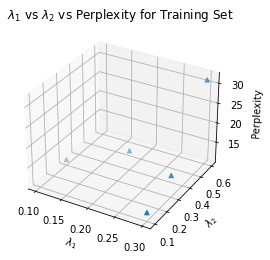

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lamdas[:, 0], lamdas[:, 1], smoothTrain, marker='^')
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('Perplexity')
plt.title('$\lambda_1$ vs $\lambda_2$ vs Perplexity for Training Set')
plt.show()

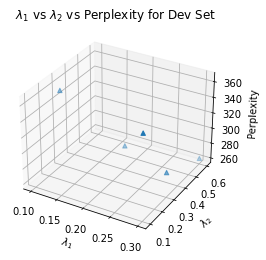

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(lamdas[:, 0], lamdas[:, 1], smoothDev, marker='^')
ax.set_xlabel('$\lambda_1$')
ax.set_ylabel('$\lambda_2$')
ax.set_zlabel('Perplexity')
plt.title('$\lambda_1$ vs $\lambda_2$ vs Perplexity for Dev Set')
plt.show()

In [16]:
for i in range(len(l)):
    print('train:', smoothTrain[i])
    print('dev:', smoothDev[i])
    print(l[i])

train: 11.151493208701995
dev: 352.2341845188709
[0.1, 0.3]
train: 15.300892892215922
dev: 286.63486984513986
[0.3, 0.3]
train: 14.6972363045192
dev: 286.36151780521215
[0.2, 0.4]
train: 31.16995276053765
dev: 261.59781170012275
[0.3, 0.6]
train: 11.966576562787939
dev: 364.0940542273087
[0.3, 0.1]


In [17]:
devMin = np.argmin(np.array(smoothDev))

t = smoothPerp(triTrain, uniModel, biModel, triModel, lamdas[devMin,0], lamdas[devMin,1])
d = smoothPerp(triDev, uniModel, biModel, triModel, lamdas[devMin,0], lamdas[devMin,1])
testP = smoothPerp(triTest, uniModel, biModel, triModel, lamdas[devMin,0], lamdas[devMin,1])
print(t)
print(d)
print(testP)

31.16995276053765
261.59781170012275
261.53193932992315


# 4.3.3

In [30]:
numData = len(trainGrid)
halfTrain = trainGrid[0:int(len(trainGrid)/2)]

In [31]:
uniHalf = unigramTrain(halfTrain)
biHalf = ngramTrain(halfTrain, 2)
triHalf = ngramTrain(halfTrain, 3)

halfVocabSet = getUnique(halfTrain)

halfTrain = prepTrain(halfVocabSet, halfTrain, 3)
halfDev = prepTrain(halfVocabSet, devGrid, 3)
halfTest = prepTrain(halfVocabSet, testGrid, 3)


In [32]:
devMin = np.argmin(np.array(smoothDev))

halfTrainPerp = smoothPerp(halfTrain, uniHalf, biHalf, triHalf, lamdas[devMin,0], lamdas[devMin,1])
halfDevPerp = smoothPerp(halfDev, uniHalf, biHalf, triHalf, lamdas[devMin,0], lamdas[devMin,1])
halfTestPerp = smoothPerp(halfTest, uniHalf, biHalf, triHalf, lamdas[devMin,0], lamdas[devMin,1])
print(halfTrainPerp)
print(halfDevPerp)
print(halfTestPerp)

26.149198619418037
247.02824400889065
247.7061378730253


# 4.3.4

In [34]:
fiveUnkUni = unigramTrain(trainGrid, minFreq=5)
fiveUnkBi = ngramTrain(trainGrid, 2, minFreq=5)
fiveUnkTri = ngramTrain(trainGrid, 3, minFreq=5)
fiveVocabSet = getUnique(trainGrid, minFreq=5)

fiveTrain = prepTrain(fiveVocabSet, trainGrid, 3)
fiveDev = prepTrain(fiveVocabSet, devGrid, 3)
fiveTest = prepTrain(fiveVocabSet, testGrid, 3)

fiveTrainPerp = smoothPerp(fiveTrain, fiveUnkUni, fiveUnkBi, fiveUnkTri, lamdas[devMin,0], lamdas[devMin,1])
fiveDevPerp = smoothPerp(fiveDev, fiveUnkUni, fiveUnkBi, fiveUnkTri, lamdas[devMin,0], lamdas[devMin,1])
fiveTestPerp = smoothPerp(fiveTest, fiveUnkUni, fiveUnkBi, fiveUnkTri, lamdas[devMin,0], lamdas[devMin,1])
print(fiveTrainPerp)
print(fiveDevPerp)
print(fiveTestPerp)

32.57992391019437
220.63705644266554
220.66245286878663
